In [26]:
import scipy.io
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import time
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
import shutil
import itertools
import xgboost as xgb
import scikitplot as skplt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.utils import class_weight

In [27]:
import warnings
warnings.filterwarnings('ignore')

## Labels Names

In [28]:
indianpines_class_names = ['background',
                           'alfalfa',           'corn-notill',               'corn-min',               'corn',
                           'grass/pasture',     'grass/trees',    'grass/pasture-mowed',      'hay-windrowed',
                           'oats',          'soybeans-notill',           'soybeans-min',      'soybean-clean',
                           'wheat',                   'woods', 'bldg-grass-tree-drives', 'stone-steel towers']

## Define Draw Classification Map

In [29]:
def draw_classification_map(classifier_name, prediction, X, y, train_indices, test_indices):
    clmap = [0]*X.shape[0]
    for i in range(len(train_indices)):
        clmap[train_indices[i]] = y[train_indices[i]]

    for i in range(len(test_indices)):
        clmap[test_indices[i]] = prediction[i]

    plt.figure(figsize=(10, 10))
    plt.imshow(np.array(clmap).reshape((145, 145)), cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.title(f'Classification Map ({classifier_name})')
    plt.savefig(f'{classifier_name}_classification_map.png')
    plt.show()

## Define Distribution Plot

In [30]:
def distribution_plot(n, df):
    plt.figure(figsize=(16, 6))
    sns.distplot(df['band-' + str(n)], color='mediumSpringGreen', bins=100, hist_kws={'alpha': 0.4})
    plt.xlabel('Band - ' + str(n), fontsize=14)
    plt.title('Distribution Plot of Band - ' + str(n), fontsize=16)
    plt.show()

## Define Box Plot

In [31]:
def box_plot(n, df):
    plt.figure(figsize=(16, 6))
    sns.boxplot(x=df["class"], y=df['band-' + str(n)], width=0.3)
    plt.title('Box Plot', fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel(f'Band-{n}', fontsize=14)
    plt.show()

## Define Bar Plot

In [32]:
def bar_plot(df):
    plt.figure(figsize=(14, 8))
    ax = sns.countplot(x='class', data=df[['class']])
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100 * p.get_height() / df.shape[0]), (p.get_x() + 0.1, p.get_height() + 5))
    plt.ylabel('Class count with percentage', fontsize=14)
    plt.xlabel('class', fontsize=14)
    plt.title('Bar Plot', fontsize=16)
    plt.show()

## Define List to Array

In [33]:
def list2array(X):
    return np.array([np.asarray(item, dtype=float) for item in X])

## Define Confusion Matrix

In [34]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title='Confusion Matrix',
                          normalize=False,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'{title}.png')
    plt.show()

## Define Save Report

In [35]:
def save_report(filename, metrics, report, best_params, train_acc):
    with open(filename, "w") as file:
        file.write("Classification Report:\n")
        file.write(str(report))
        file.write(f'\n{str(train_acc)}')
        file.write(f"\n{str(metrics)}\n")
        file.write("\nBest Parameters:\n")
        file.write(str(best_params))

## Classification Pipeline

In [36]:
from sklearn.model_selection import StratifiedKFold


def run_classification_pipeline(X_train, X_test, y_train, y_test, classifier_name, classifier, param_grid, cv_folds=5):

    resample_strategy = SMOTE(sampling_strategy='auto', random_state=1)
    #feature_selection = SelectFromModel(RandomForestClassifier(n_estimators=100))
    # pca = PCA(n_components=100)  # Retains 95% of variance
    start_time = time.time()
    # Define a pipeline that includes scaling, SMOTE, and the classifier
    steps = [#('scaler', MinMaxScaler()),
            #('feature_selection', feature_selection),
             #('pca', pca),
             ('resampling', resample_strategy),
             ('classifier', classifier)]
    pipeline = ImbPipeline(steps=steps)

    # Define the cross-validator
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Set up the grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Best model evaluation on the test set
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)

    print(f'{classifier_name} Train_Acc={grid_search.score(X_train, y_train):.3f}, Test_Cla_Acc={grid_search.score(X_test, y_test):.3f}, time_cost={time.time()-start_time:.3f}')

    return best_model, grid_search, best_params, y_pred


## Load Data

In [37]:
df_soil = pd.read_csv("dataset/Dataset_hyper.csv")
df_soil.loc[:,'class'].value_counts()
X = df_soil.iloc[:, :-1].values
y = df_soil.iloc[:, -1].values
print(X.shape, y.shape)
height = 145
width = 145
band = 220
num_classes = 17
df_soil.head()

(21025, 220) (21025,)


,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-212,band-213,band-214,band-215,band-216,band-217,band-218,band-219,band-220,class
0,3172,4142,4237,4279,4478,4754,4808,4666,4632,4404,...,1090,1112,1090,1062,1069,1057,1020,1020,1005,3
1,2580,4266,4237,4426,4478,4754,4808,4666,4632,4404,...,1104,1117,1091,1079,1085,1064,1029,1020,1000,3
2,3687,4266,4421,4126,4478,4754,4808,4666,4632,4404,...,1114,1114,1100,1065,1092,1061,1030,1016,1009,3
3,2780,4258,4603,4126,4478,4754,4808,4666,4632,4404,...,1108,1109,1109,1071,1088,1060,1030,1006,1005,3
4,2746,4018,4675,4417,4478,4754,4808,4666,4632,4404,...,1107,1112,1094,1072,1087,1052,1034,1019,1019,3


## Plot Bands

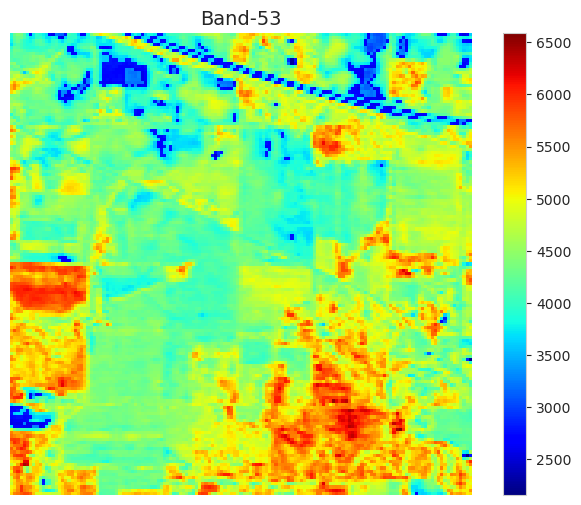

In [38]:
def plot_band(dataset):
    plt.figure(figsize=(8, 6))
    band_no = np.random.randint(dataset.shape[1])
    dataset = dataset.values.reshape(145,145,dataset.shape[1])
    plt.imshow(dataset[:,:, band_no], cmap='jet')
    plt.title(f'Band-{band_no}', fontsize=14)
    plt.axis('off')
    plt.colorbar()
    plt.show()
plot_band(df_soil)

## Visualizing ground truth of the image.

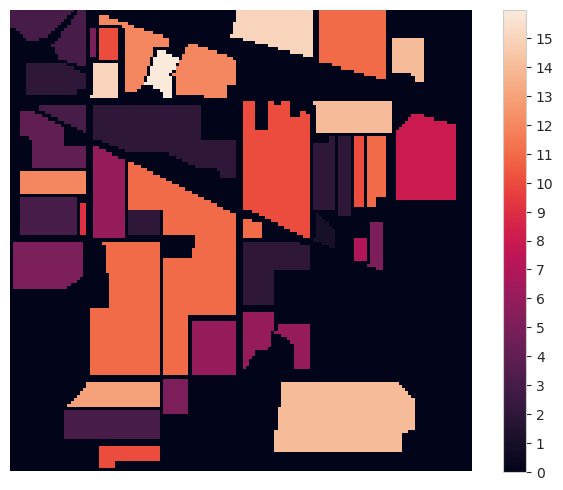

In [39]:
plt.figure(figsize=(8, 6))
ground_truth = df_soil['class']
ground_truth = ground_truth.values.reshape(145,145)
plt.imshow(ground_truth)
plt.axis('off')
plt.colorbar(ticks= range(0,16))
plt.show()

## Visualizing Spectral Signatures

Pixel No:  4096


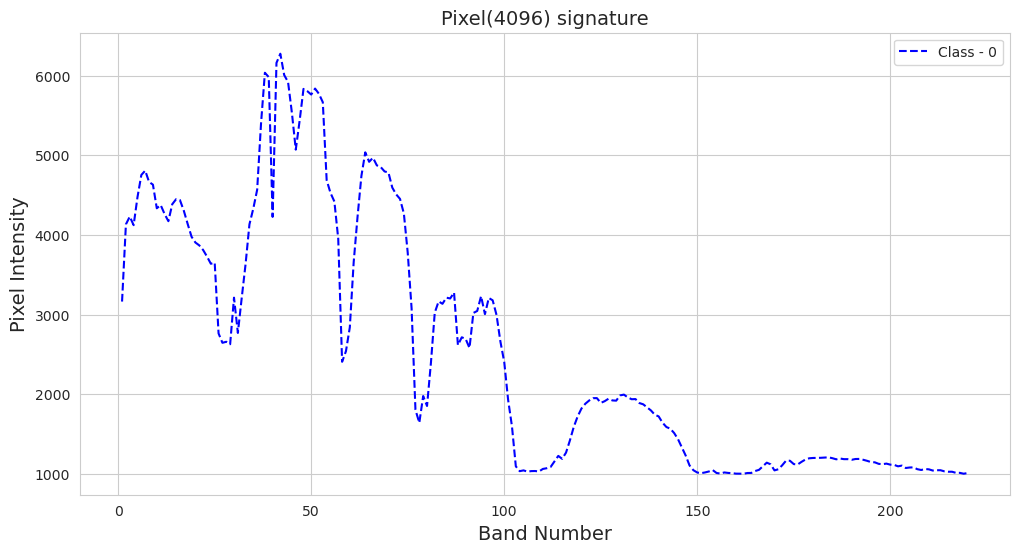

In [40]:
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    print("Pixel No: ",pixel_no)
    plt.plot(range(1, 221), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()
plot_signature(df_soil)

## Box Plot

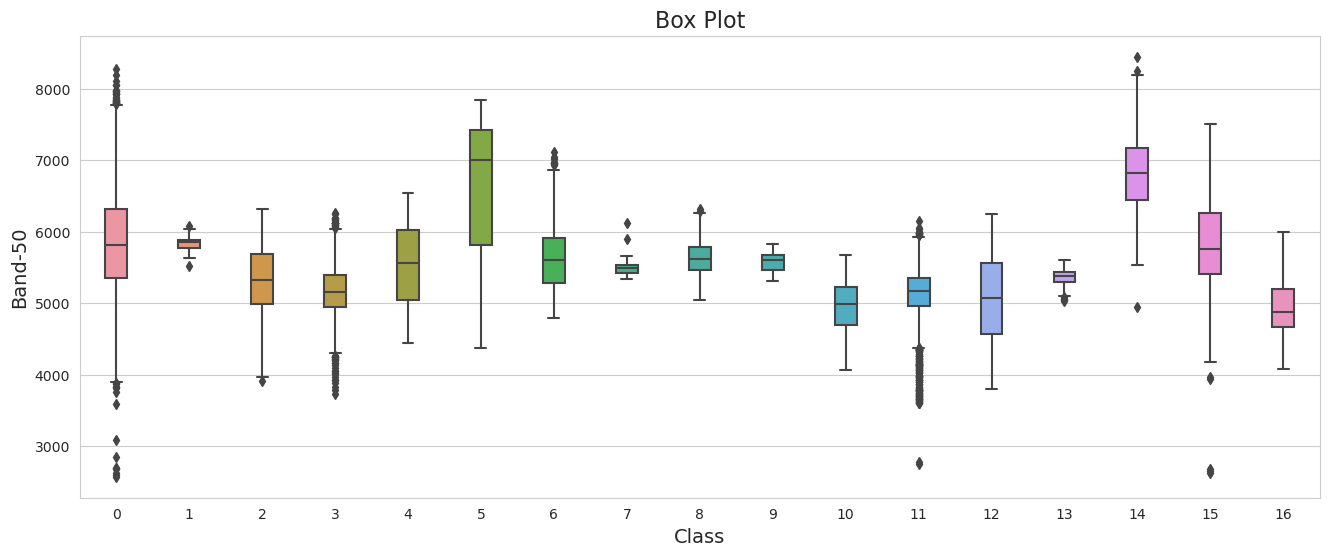

In [41]:
box_plot(50, df_soil)

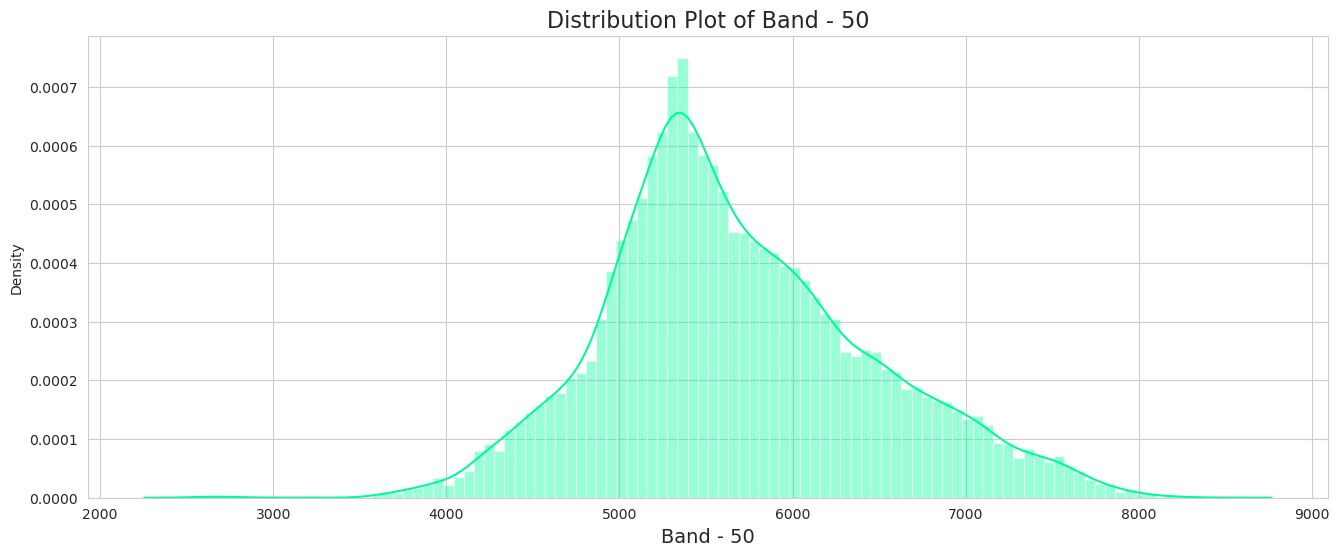

In [42]:
distribution_plot(50, df_soil)

# for i in range(1, 221):
#     distribution_plot(i, df_soil)

## Splitting and Training Data

In [43]:
X_train, X_test, y_train, y_test, train_indexes, test_indexes = \
    train_test_split(X, y, range(X.shape[0]),train_size=0.7, random_state=123, stratify=y)
train_indices = list2array(train_indexes, isdata=False)
test_indices = list2array(test_indexes, isdata=False)

## Print Data Summary

In [44]:
def print_data_summary_1(y_train,y_test,y,num_classes):
    df = pd.DataFrame(np.random.randn(num_classes, 3),
                      index=[indianpines_class_names[i] for i in range(0,num_classes)],
                      columns=['Train', 'Test', 'Total'])
    df['Train'] = [sum(y_train==i) for i in range(0,num_classes)]
    df['Total'] = [sum(y==i) for i in range(0,num_classes)]
    df['Test'] = np.array(df['Total']) - np.array(df['Train'])
    print('Summary of training and testing samples:')
    print(df)
    print("Training samples: %d" % len(y_train))
    print("Test samples: %d" % len(y_test))
print_data_summary_1(y_train, y_test, y, num_classes)


Summary of training and testing samples:
                        Train  Test  Total
background               7543  3233  10776
alfalfa                    32    14     46
corn-notill              1000   428   1428
corn-min                  581   249    830
corn                      166    71    237
grass/pasture             338   145    483
grass/trees               511   219    730
grass/pasture-mowed        20     8     28
hay-windrowed             335   143    478
oats                       14     6     20
soybeans-notill           680   292    972
soybeans-min             1718   737   2455
soybean-clean             415   178    593
wheat                     144    61    205
woods                     885   380   1265
bldg-grass-tree-drives    270   116    386
stone-steel towers         65    28     93
Training samples: 14717
Test samples: 6308


In [45]:
class_wt = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

## Standardization

In [46]:
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

## Define Classifiers

In [47]:
classifiers = {
    'KNN': (KNeighborsClassifier(), {'classifier__n_neighbors': [3]}),
    'SVM_RBF': (SVC(probability=True), {'classifier__C': [1, 10, 50, 100, 0.1], 'classifier__kernel': ['rbf'], 'classifier__gamma': ['scale']}),
    'SVM_Poly': (SVC(probability=True), {'classifier__C': [1, 10, 50, 100, 0.1], 'classifier__kernel': ['poly'], 'classifier__degree':[1,2,3,4,5,6], 'classifier__gamma': ['scale']}),
    'Xgboost':(xgb.XGBClassifier(), {'classifier__colsample_bytree': [1.0], 'classifier__eta': [0.1], 'classifier__gamma': [0], 'classifier__max_depth': [20], 'classifier__min_child_weight': [10], 'classifier__n_estimator': [3000], 'classifier__nthreads': [-1], 'classifier__num_class': [16], 'classifier__objective': ['multi:softmax'], 'classifier__subsample': [1.0], 'classifier__tree_method': ['auto']}),
    'Random_Forest': (RandomForestClassifier(), {'classifier__n_estimators': [100], 'classifier__min_samples_split': [2], 'classifier__min_samples_leaf': [1]}),
    'Gradient_Boosting': (GradientBoostingClassifier(), {'classifier__n_estimators': [300]}),
    'MLP': (MLPClassifier(), {'classifier__hidden_layer_sizes': [400, 500]})
}

In [48]:
selected_classifiers = ['Random_Forest', 'KNN', 'SVM_RBF', 'Xgboost', 'Gradient_Boosting', 'MLP', 'SVM_Poly']
classifiers_to_run = {name: classifiers[name] for name in selected_classifiers if name in classifiers}


In [49]:
classifiers_to_run

{'Random_Forest': (RandomForestClassifier(),
  {'classifier__n_estimators': [100],
   'classifier__min_samples_split': [2],
   'classifier__min_samples_leaf': [1]}),
 'KNN': (KNeighborsClassifier(), {'classifier__n_neighbors': [3]}),
 'SVM_RBF': (SVC(probability=True),
  {'classifier__C': [1, 10, 50, 100, 0.1],
   'classifier__kernel': ['rbf'],
   'classifier__gamma': ['scale']}),
 'Xgboost': (XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None

## Run Classification Pipeline

Random_Forest Train_Acc=1.000, Test_Cla_Acc=0.789, time_cost=405.346
Results for Random_Forest:
Accuracy: 0.7886810399492707%
Random_Forest Class Report: 
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      3233
           1       0.86      0.86      0.86        14
           2       0.75      0.78      0.76       428
           3       0.74      0.81      0.77       249
           4       0.59      0.77      0.67        71
           5       0.81      0.85      0.83       145
           6       0.77      0.88      0.82       219
           7       0.67      0.50      0.57         8
           8       0.84      0.97      0.90       143
           9       1.00      0.17      0.29         6
          10       0.76      0.88      0.82       292
          11       0.74      0.85      0.79       737
          12       0.63      0.81      0.71       178
          13       0.87      0.97      0.91        61
          14       0.52      0.81

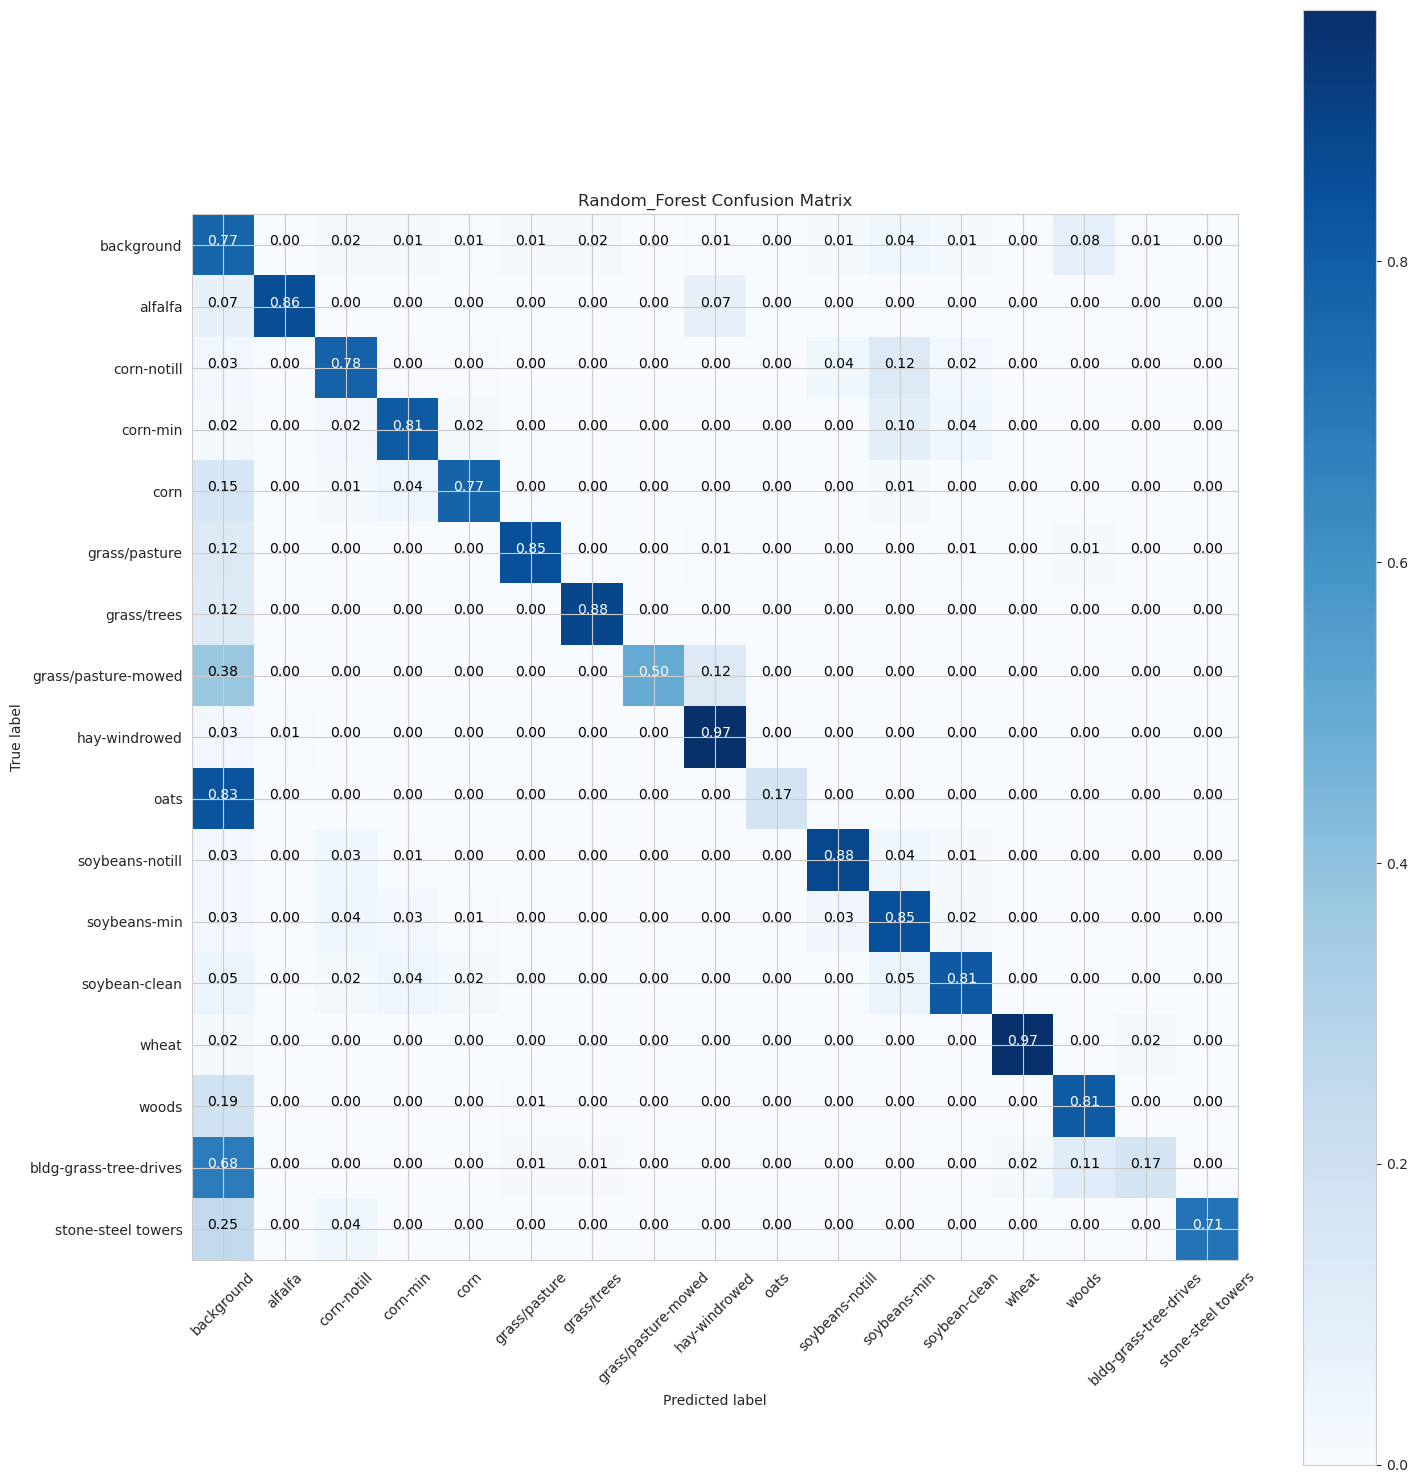

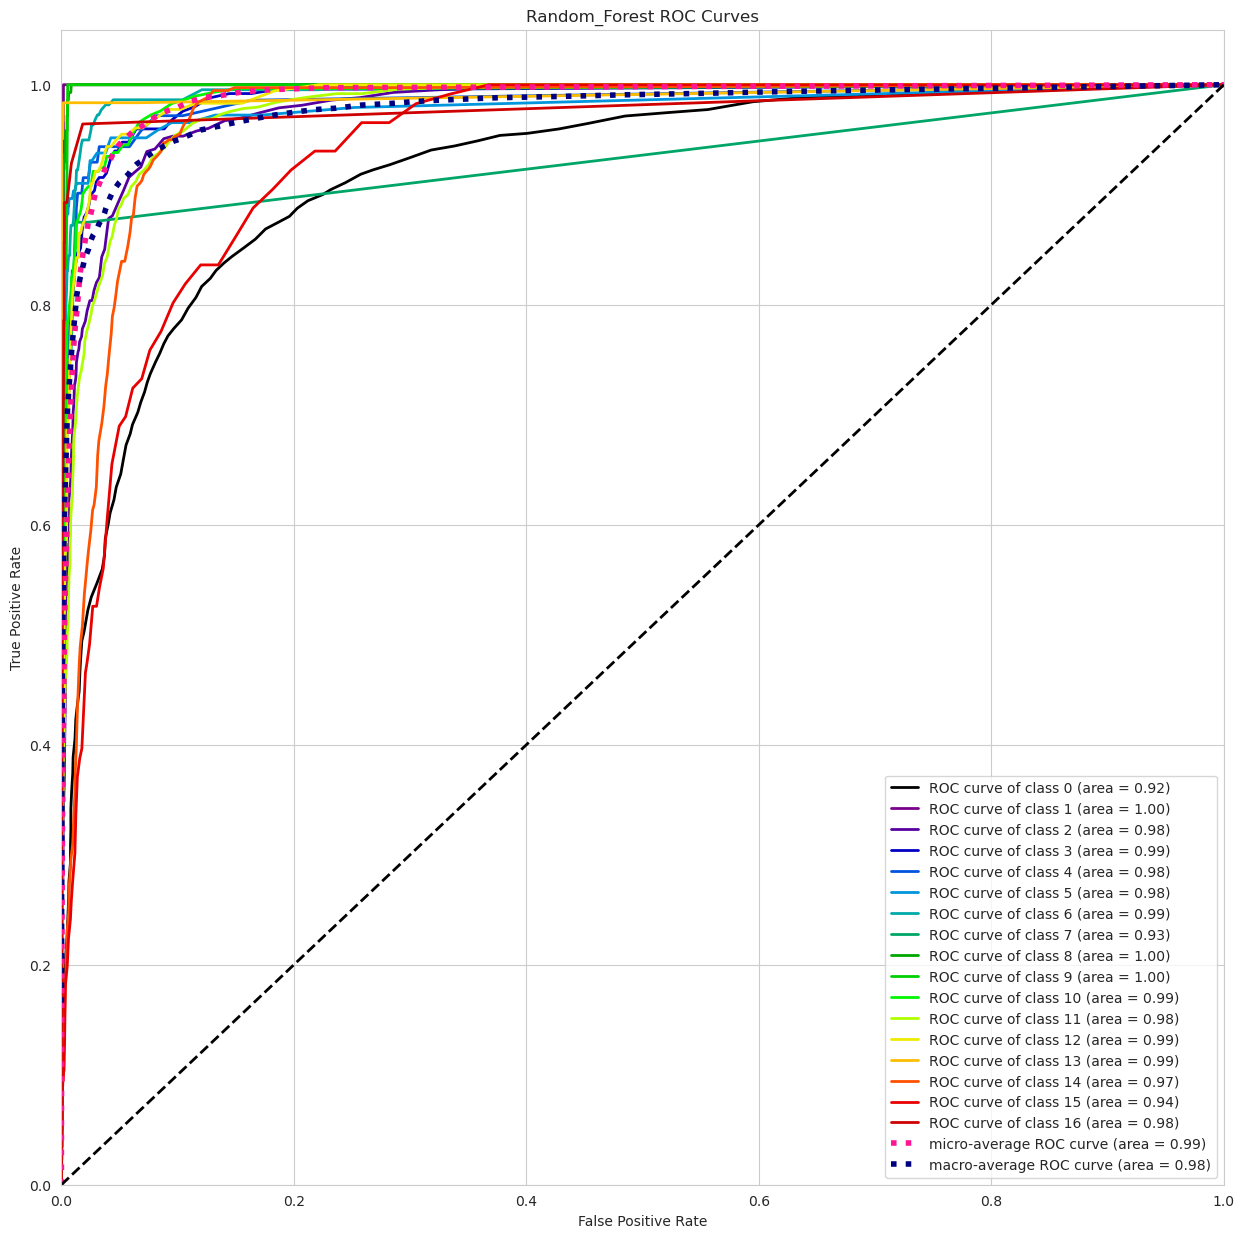

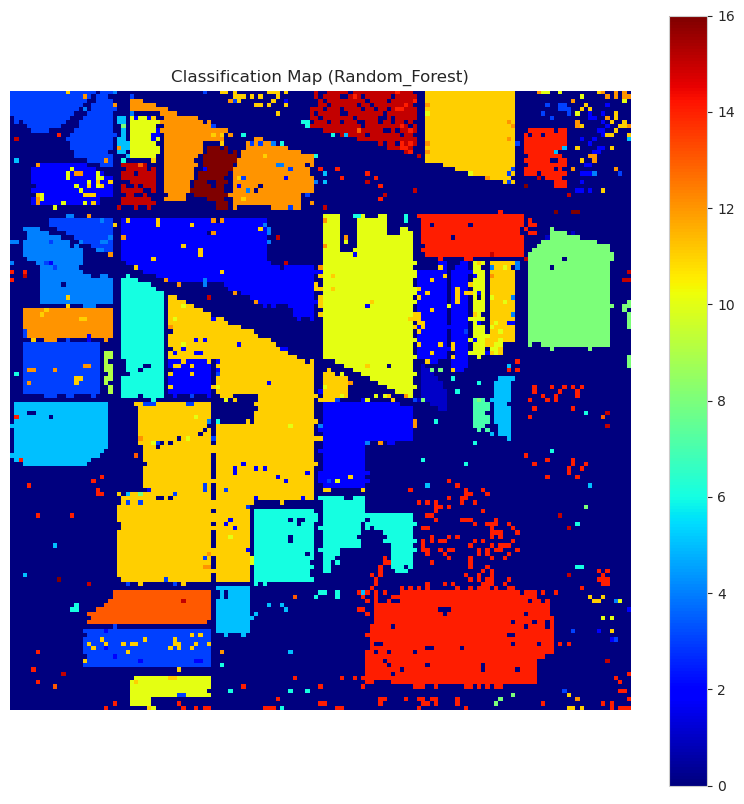

--------------------------------------------------------------------------------
KNN Train_Acc=0.712, Test_Cla_Acc=0.445, time_cost=7.480
Results for KNN:
Accuracy: 0.44499048826886495%
KNN Class Report: 
               precision    recall  f1-score   support

           0       0.92      0.25      0.39      3233
           1       0.25      0.50      0.33        14
           2       0.43      0.50      0.46       428
           3       0.40      0.58      0.47       249
           4       0.29      0.61      0.40        71
           5       0.31      0.83      0.45       145
           6       0.33      0.89      0.48       219
           7       0.36      0.62      0.45         8
           8       0.71      0.97      0.82       143
           9       0.24      1.00      0.39         6
          10       0.40      0.64      0.49       292
          11       0.59      0.57      0.58       737
          12       0.29      0.48      0.36       178
          13       0.45      0.93    

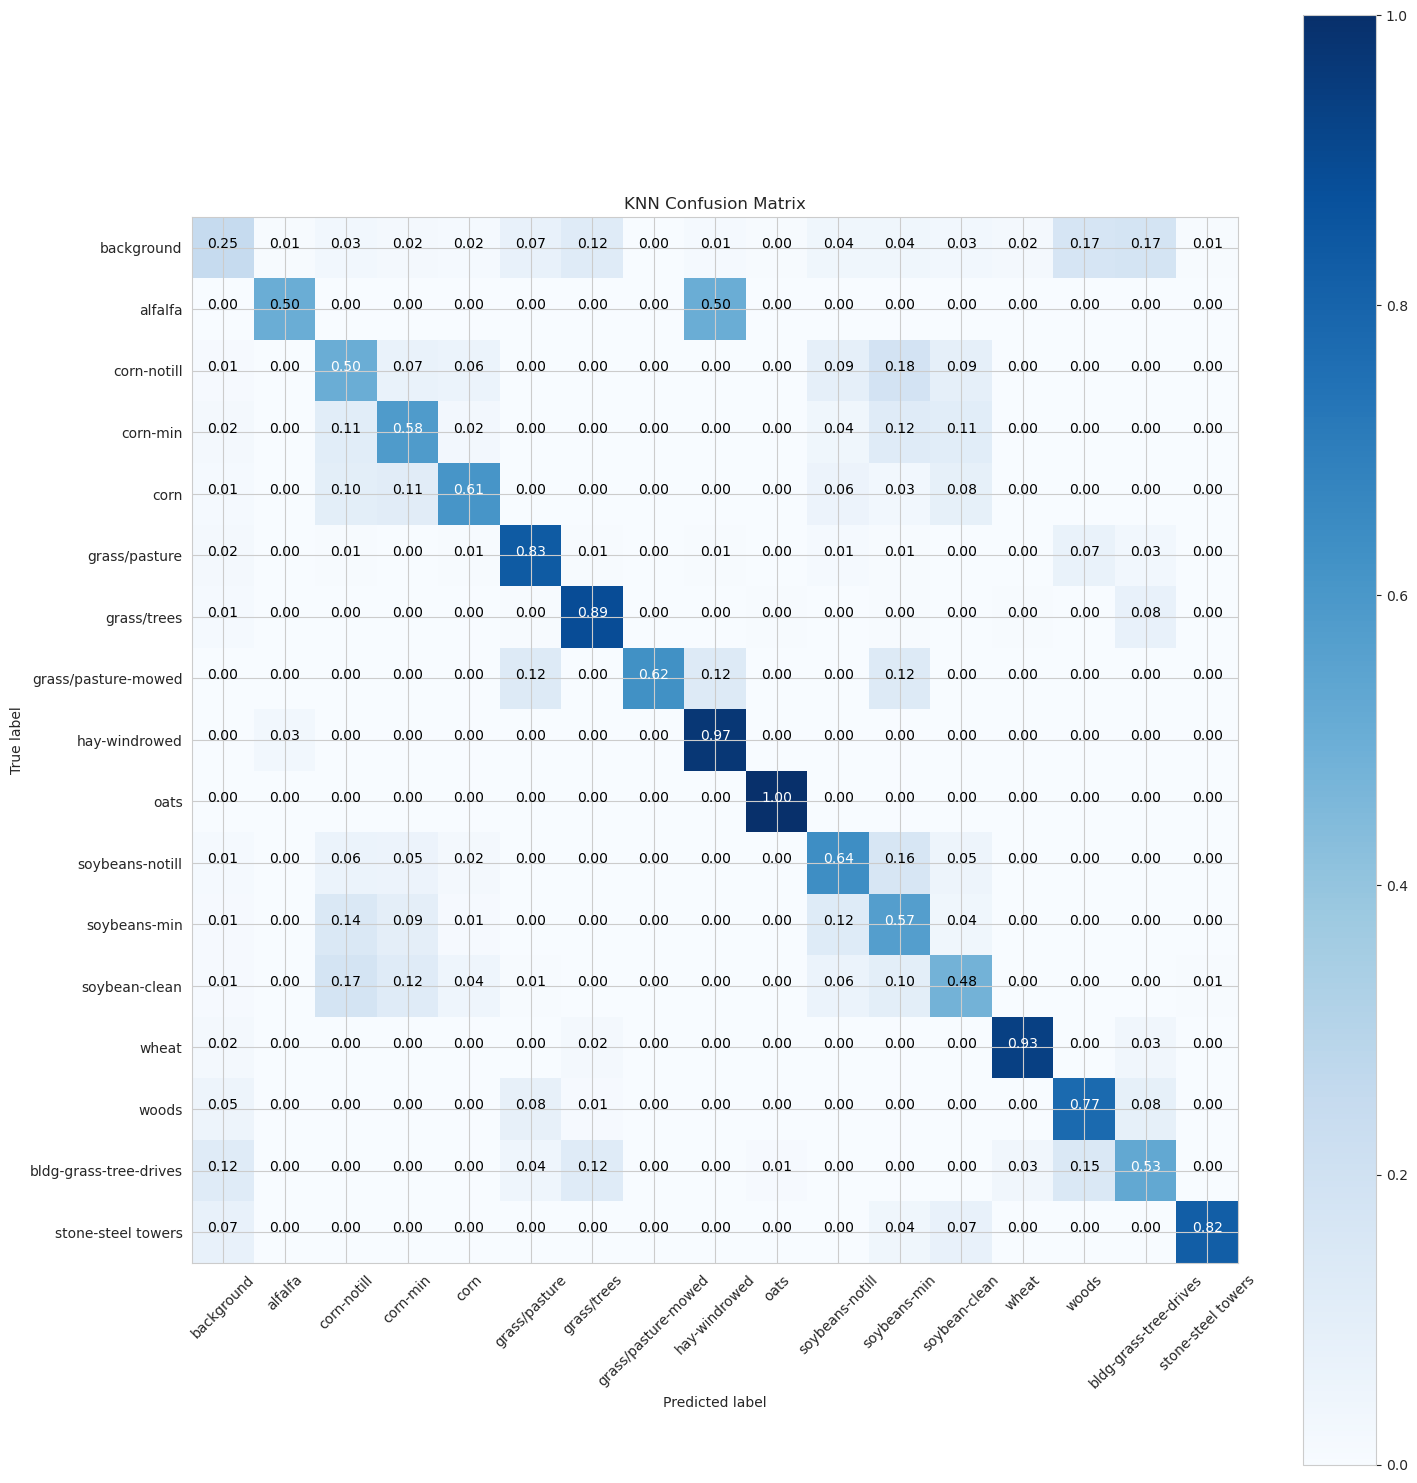

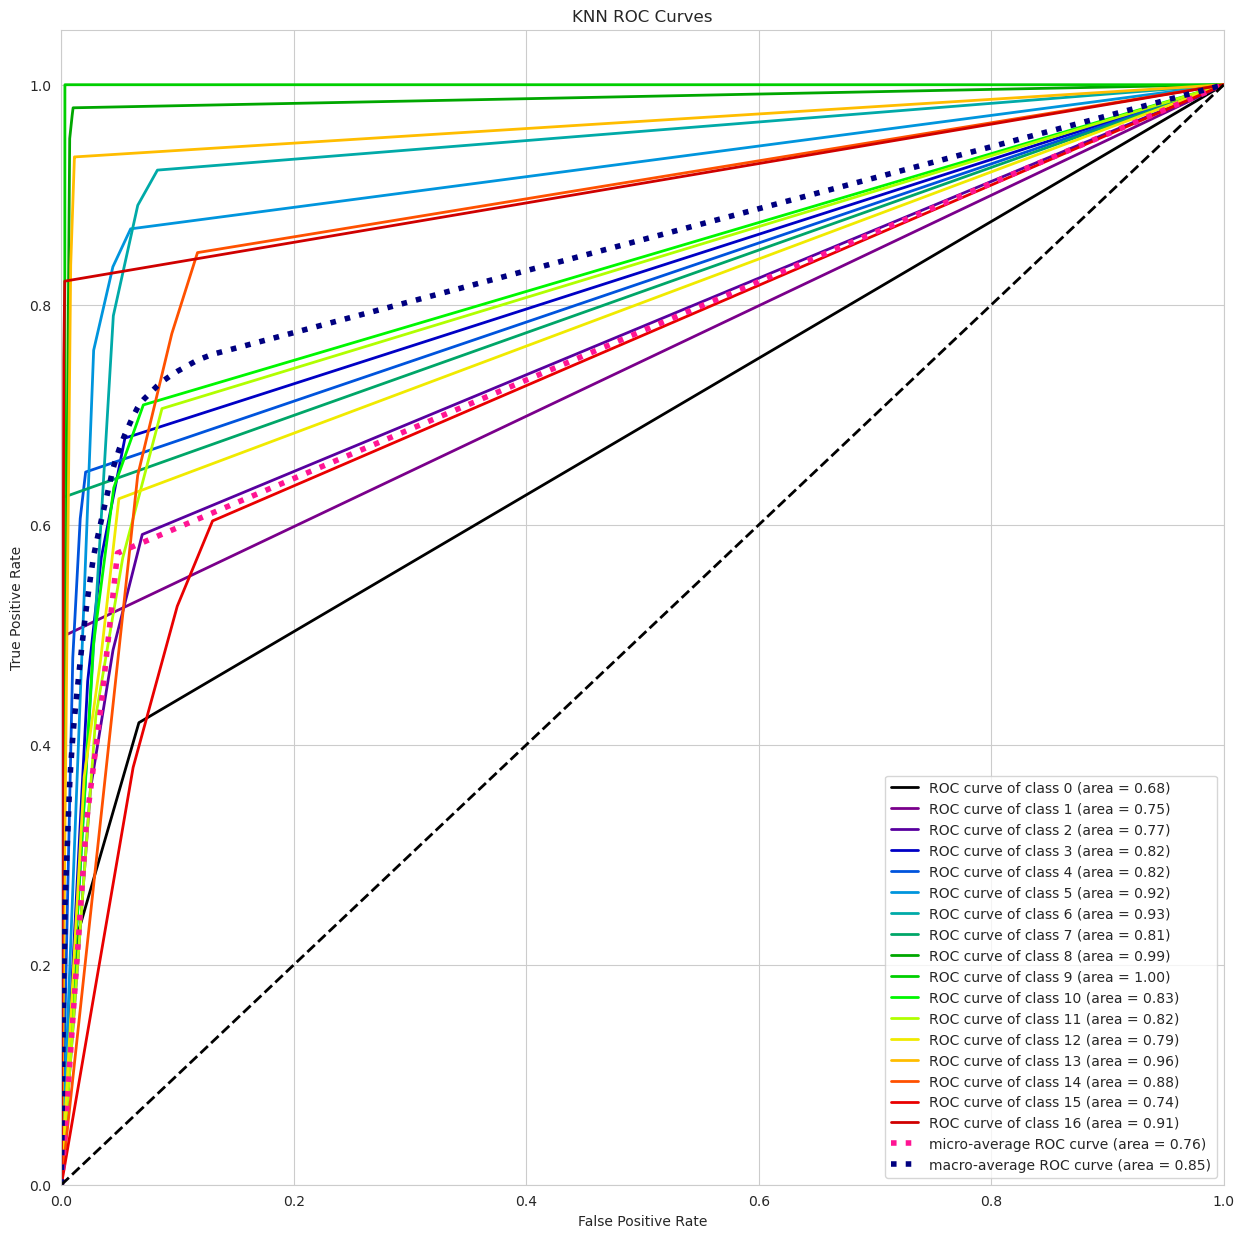

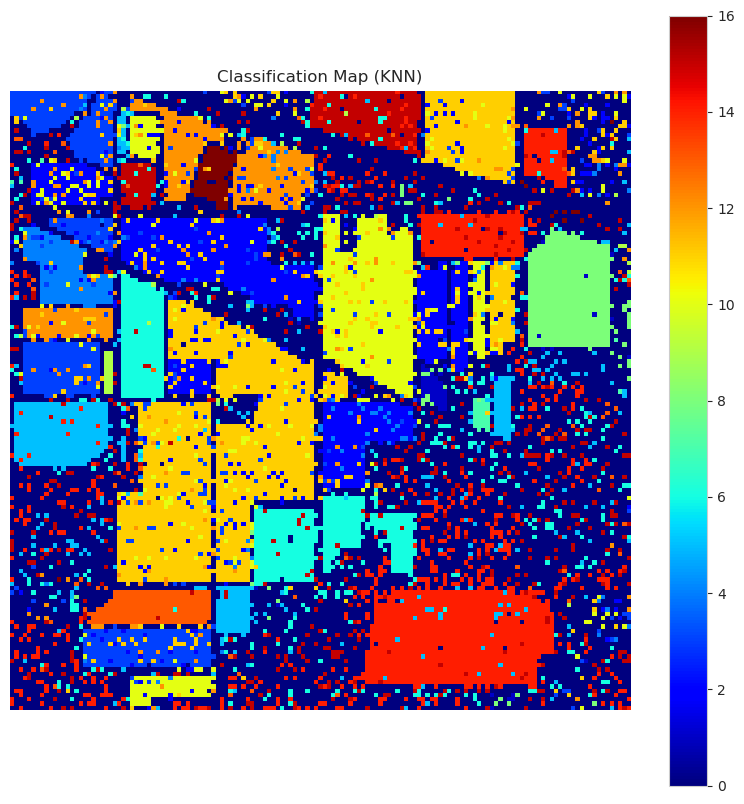

--------------------------------------------------------------------------------
SVM_RBF Train_Acc=0.971, Test_Cla_Acc=0.794, time_cost=1936.144
Results for SVM_RBF:
Accuracy: 0.7939124920735574%
SVM_RBF Class Report: 
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      3233
           1       0.75      0.64      0.69        14
           2       0.74      0.75      0.74       428
           3       0.80      0.76      0.78       249
           4       0.71      0.59      0.65        71
           5       0.86      0.79      0.83       145
           6       0.81      0.84      0.82       219
           7       0.75      0.38      0.50         8
           8       0.92      0.91      0.92       143
           9       0.60      0.50      0.55         6
          10       0.74      0.76      0.75       292
          11       0.81      0.82      0.81       737
          12       0.82      0.85      0.83       178
          13       0.92

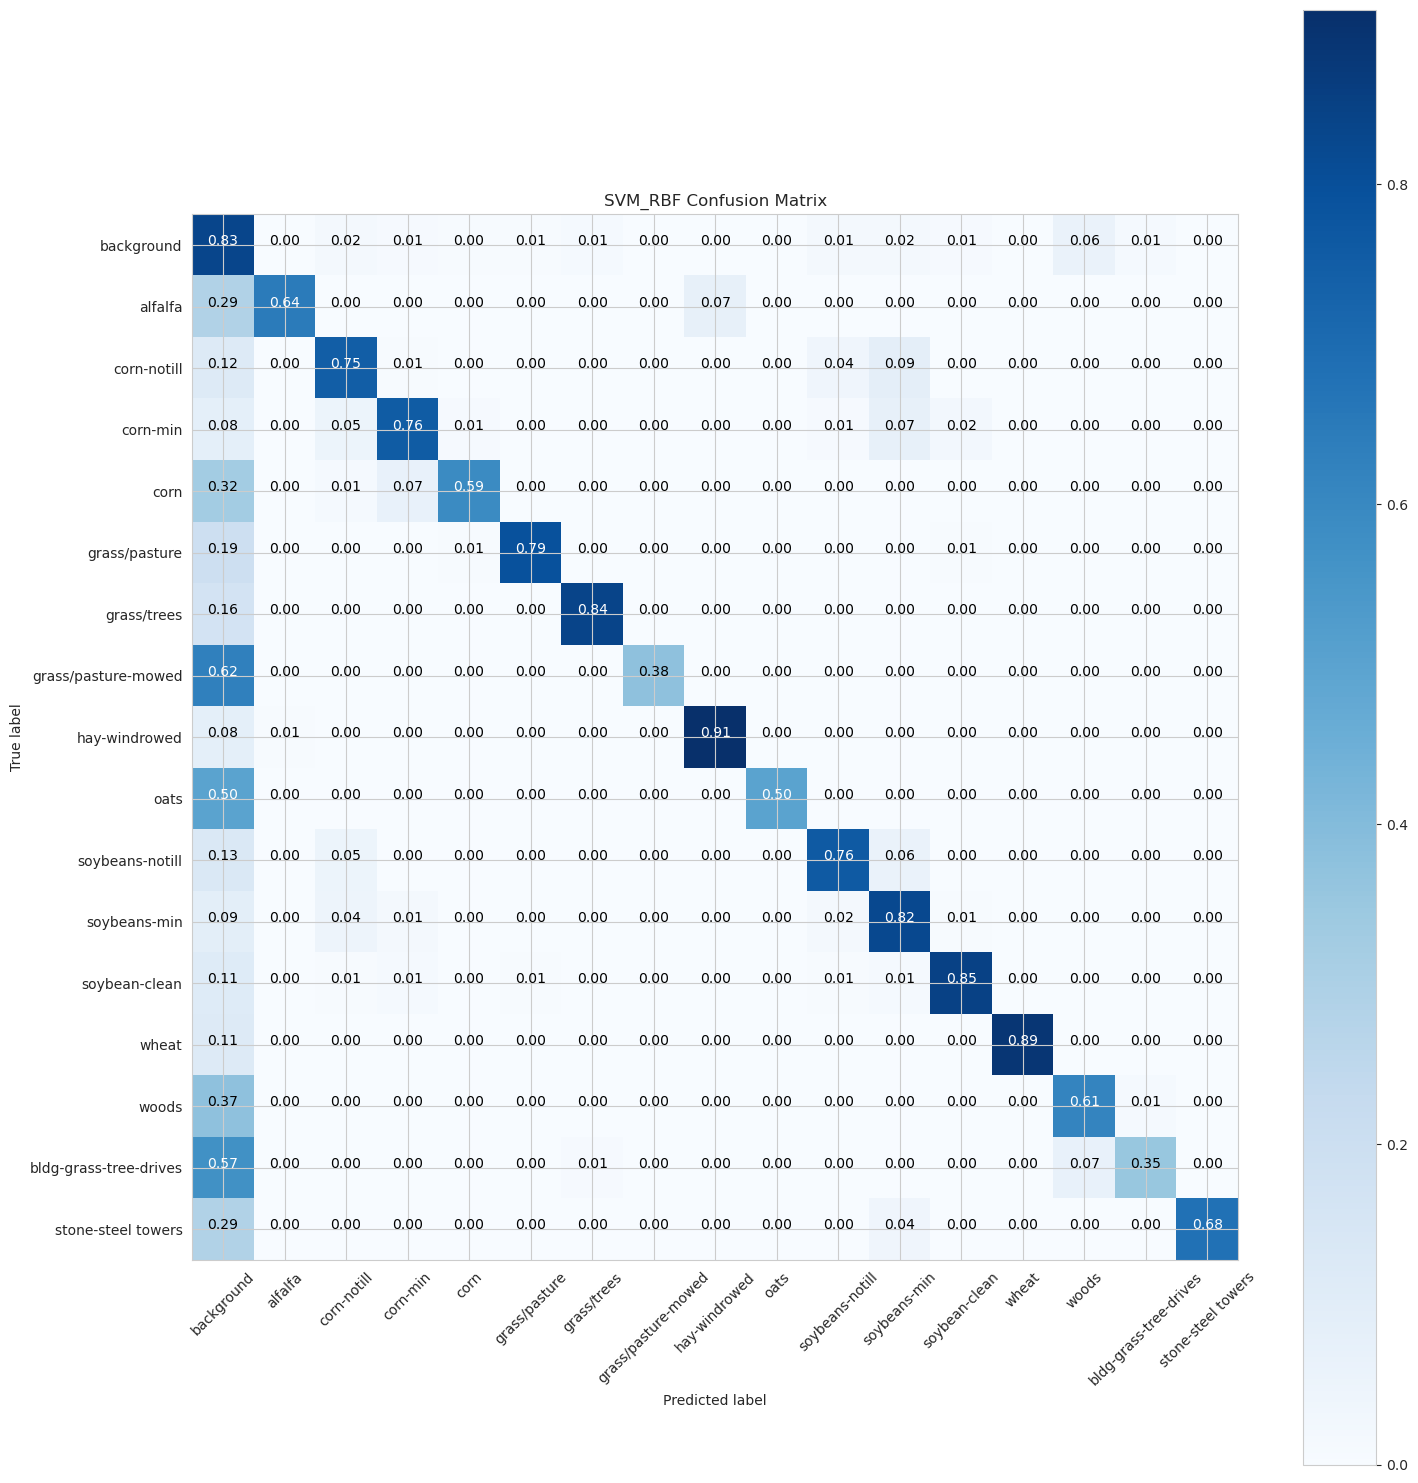

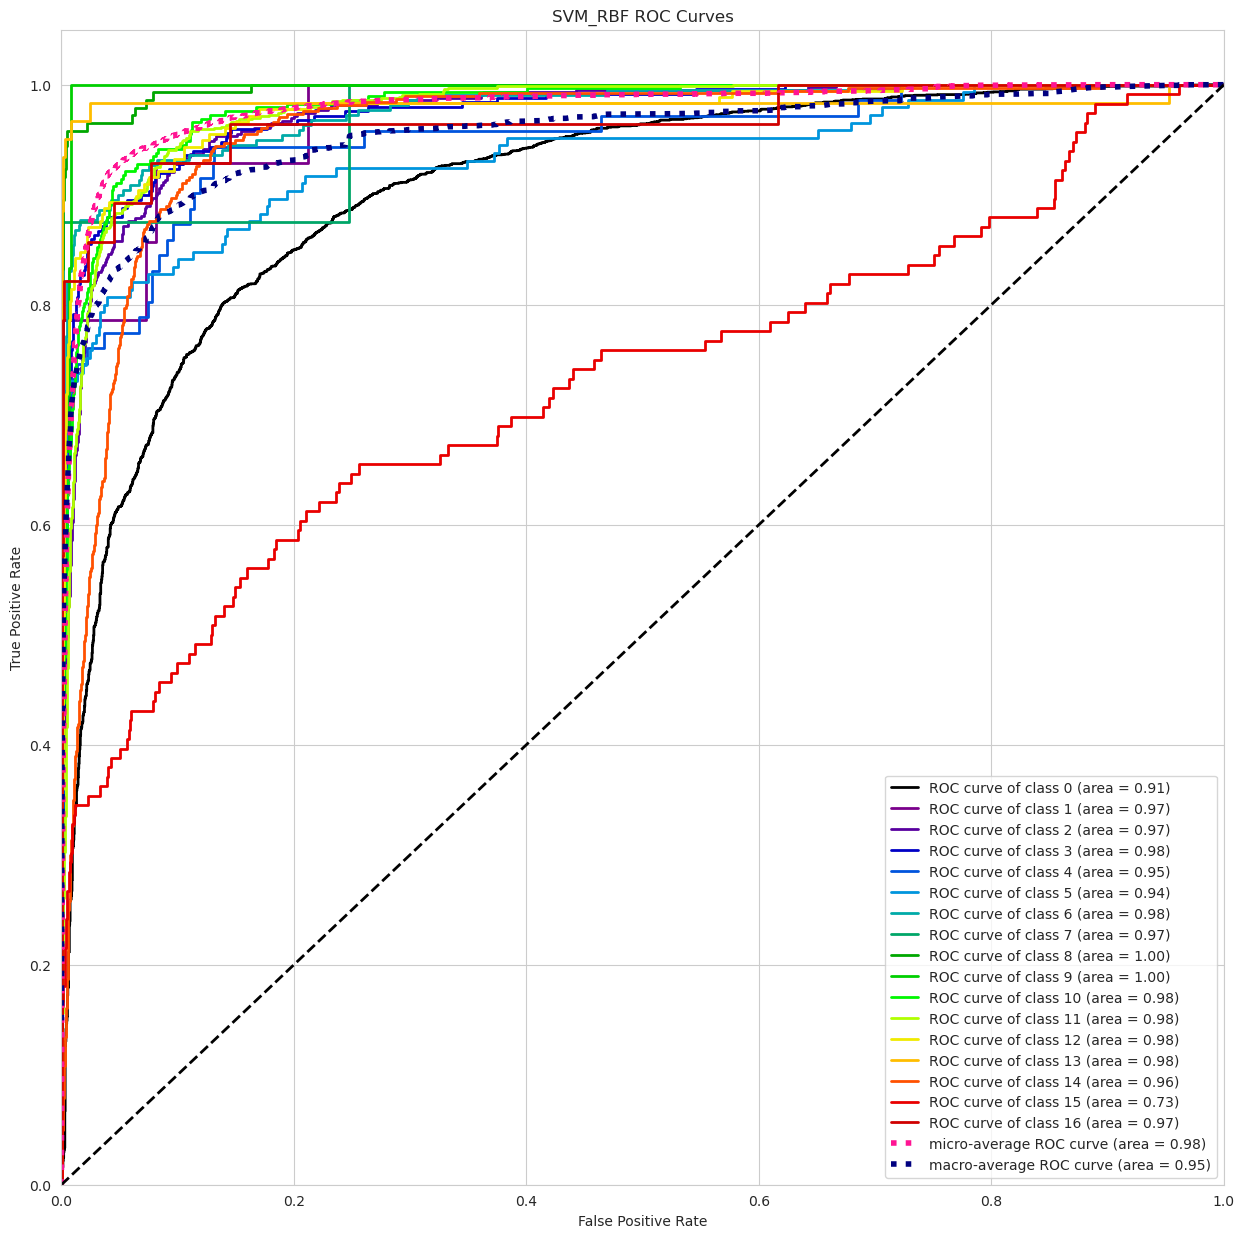

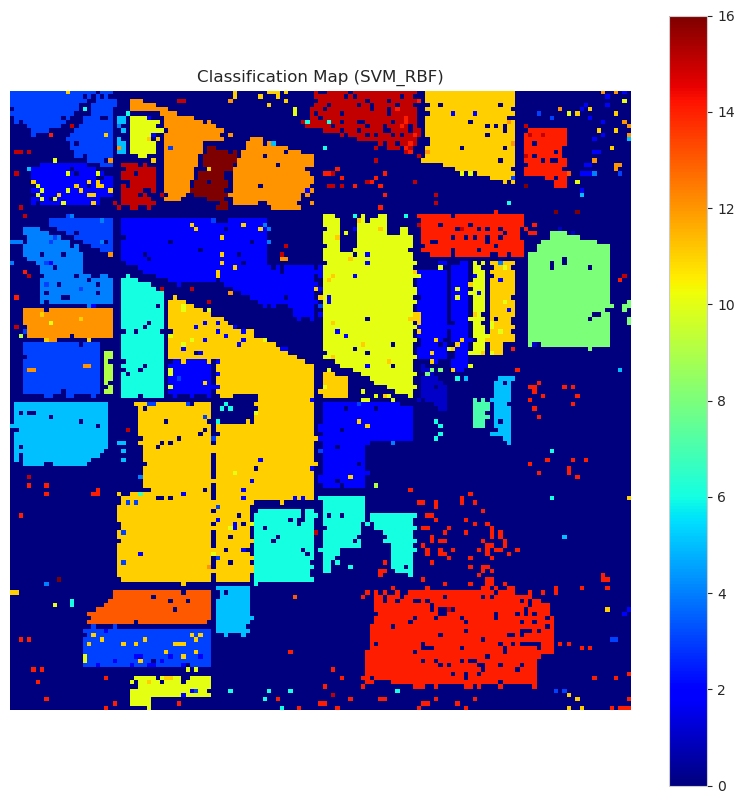

--------------------------------------------------------------------------------


/data/ddoshi/anaconda3/envs/project_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:37:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705649946806/work/src/learner.cc:742: 
Parameters: { "n_estimator", "nthreads" } are not used.

  warnings.warn(smsg, UserWarning)
/data/ddoshi/anaconda3/envs/project_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:37:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705649946806/work/src/learner.cc:742: 
Parameters: { "n_estimator", "nthreads" } are not used.

  warnings.warn(smsg, UserWarning)
/data/ddoshi/anaconda3/envs/project_env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:37:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705649946806/work/src/learner.cc:742: 
Parameters: { "n_estimator", "nthreads" } are not used.

  warnings.warn(smsg, UserWarning)
/data/ddoshi/anaconda3/envs/project_env/lib/python3.10/site-pack

Xgboost Train_Acc=1.000, Test_Cla_Acc=0.814, time_cost=255.728
Results for Xgboost:
Accuracy: 0.813570069752695%
Xgboost Class Report: 
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      3233
           1       0.67      0.71      0.69        14
           2       0.81      0.79      0.80       428
           3       0.86      0.75      0.80       249
           4       0.64      0.66      0.65        71
           5       0.90      0.77      0.83       145
           6       0.81      0.82      0.82       219
           7       0.67      0.50      0.57         8
           8       0.89      0.92      0.91       143
           9       0.25      0.17      0.20         6
          10       0.80      0.83      0.81       292
          11       0.80      0.85      0.82       737
          12       0.70      0.73      0.72       178
          13       0.90      0.98      0.94        61
          14       0.64      0.65      0.65       38

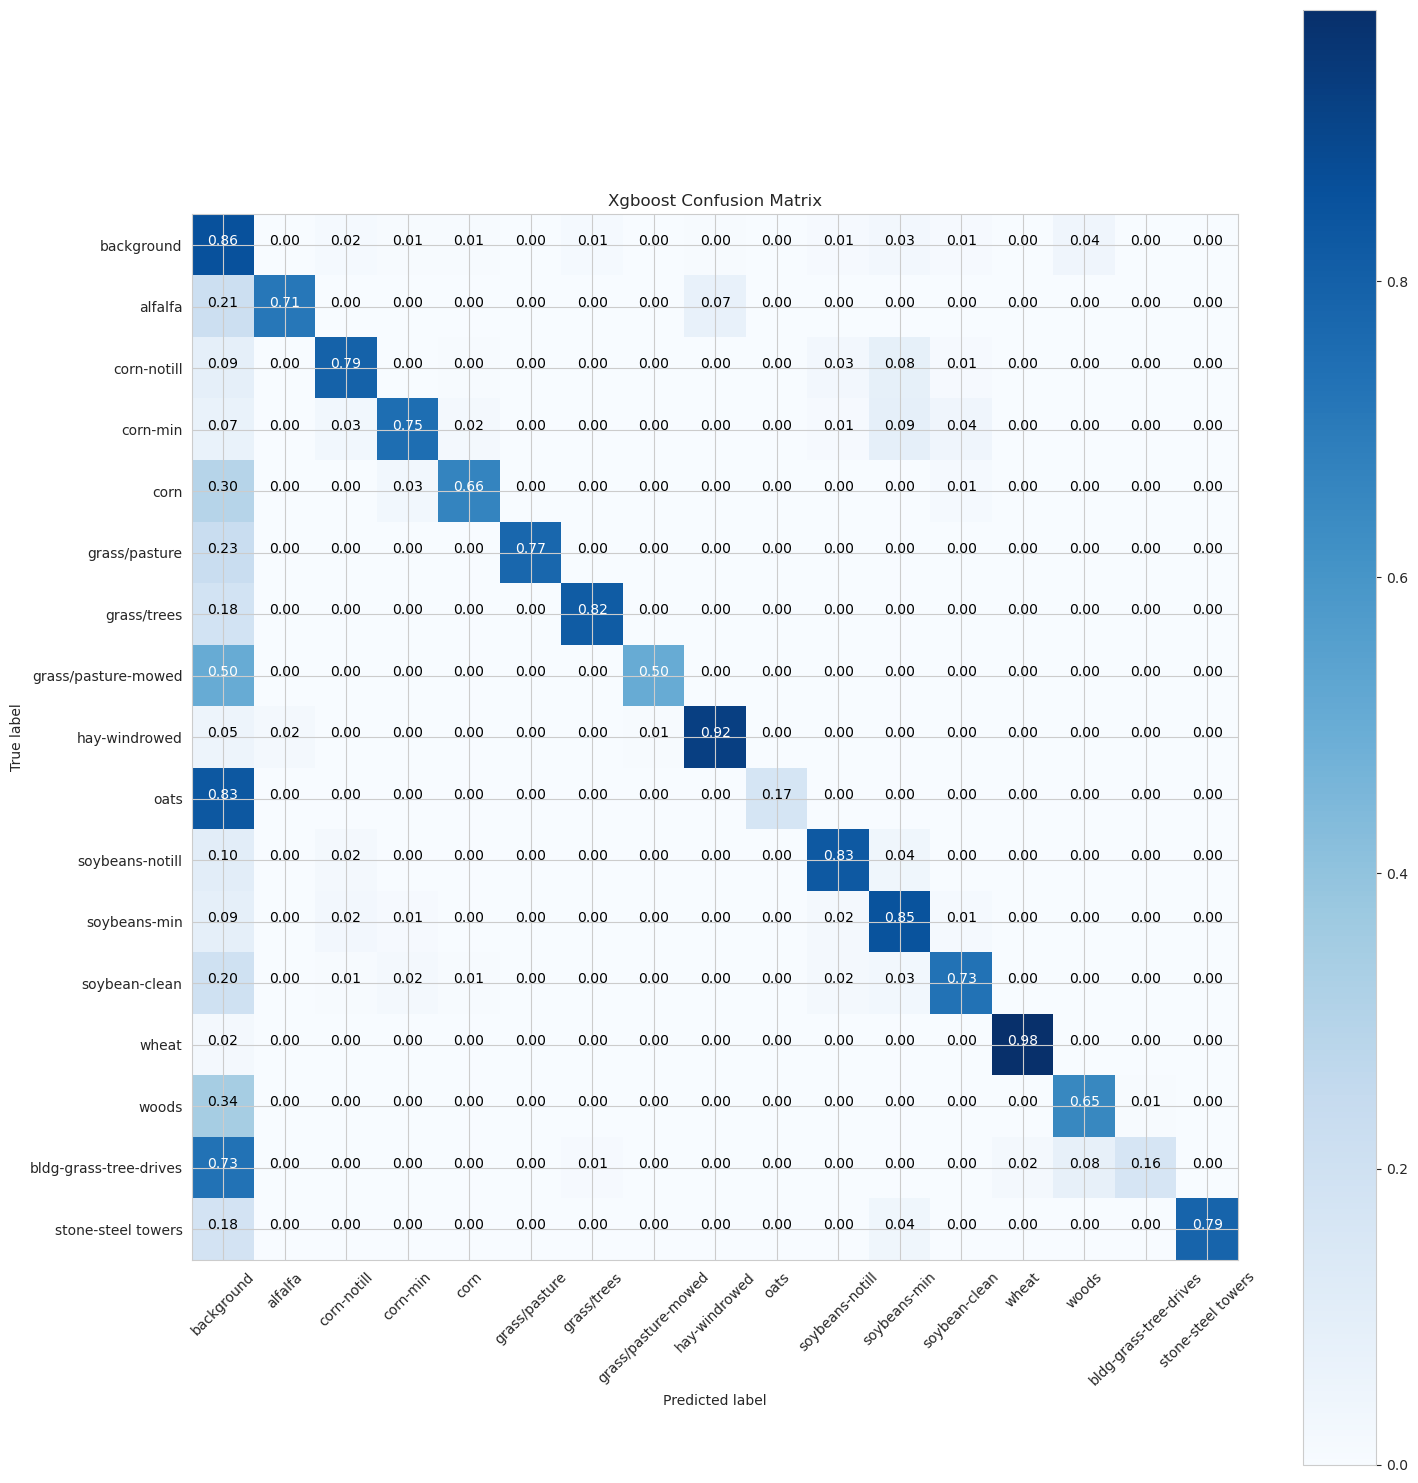

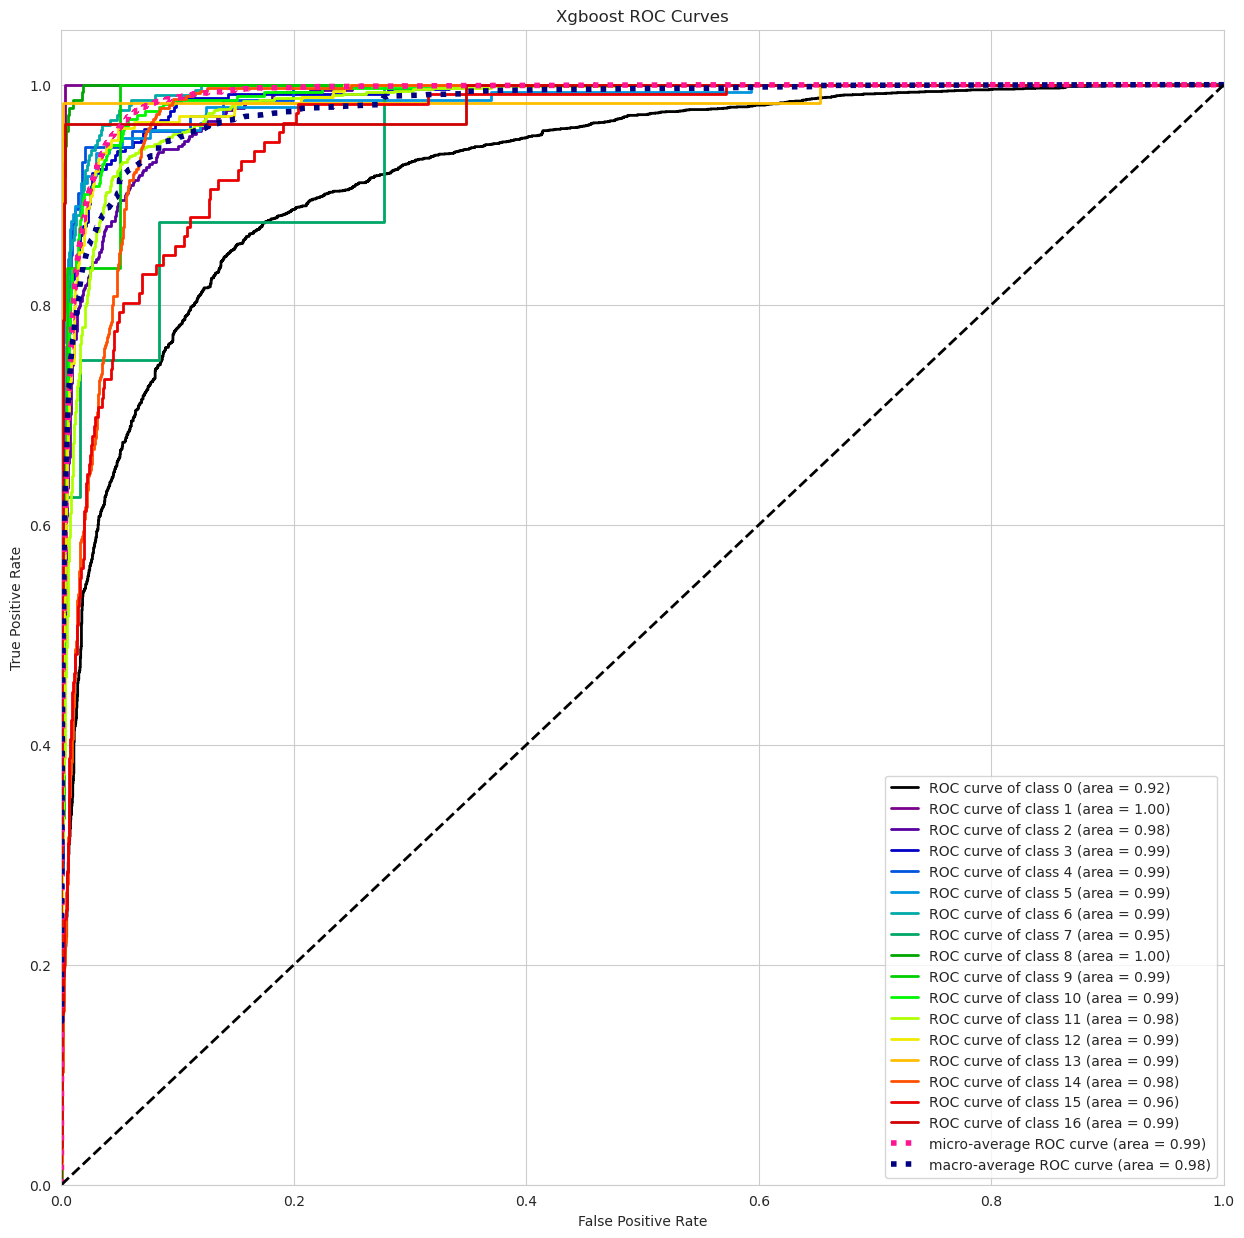

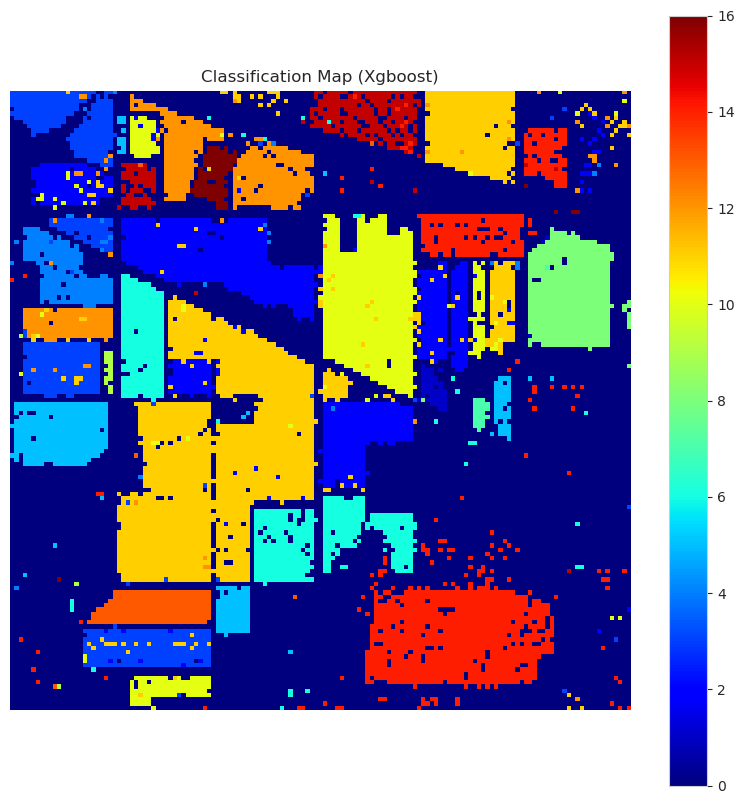

--------------------------------------------------------------------------------


In [ ]:
for name, (classifier, params) in classifiers_to_run.items():
    best_model, grid_search, best_param, prediction = run_classification_pipeline(X_train=X_train_scaler,y_train=y_train,X_test=X_test_scaler, y_test=y_test,classifier_name=name, classifier=classifier, param_grid=params)

    print(f"Results for {name}:")
    print(f'Accuracy: {accuracy_score(y_test, prediction)}%')
    print(f"{name} Class Report: \n", classification_report(y_test, prediction))
    plot_confusion_matrix(y_test, prediction, classes=indianpines_class_names, normalize=True, title=f'{name} Confusion Matrix')
    prob = best_model.predict_proba(X_test_scaler)
    skplt.metrics.plot_roc(y_test, prob, title=f'{name} ROC Curves', figsize=(15, 15))
    draw_classification_map(name, prediction, X, y, train_indexes, test_indexes)
    save_report(f'{name}_report.txt', accuracy_score(y_test, prediction), classification_report(y_test, prediction), best_param, grid_search.score(X_train_scaler, y_train))
    print("-" * 80)


In [ ]:
# print_data_summary_1(y_train, y_test, y_train1, num_classes)
# num_train_each_class = np.array([np.sum(y_train==i+1) for i in range(num_classes)])
# print(num_train_each_class.shape)
# classifiers = ["KNN","RBF-SVM"]#,"Poly-SVM", "Xgboost", "RF", "GB","MLR"]
# model_selection = False

In [ ]:
# Cla_accuracy = np.zeros((np.size(classifiers),1))
#         

In [ ]:
# for i in range(len(classifiers)):
#         
#         classifier = classifiers[i]
#         Cla_Map,cla_accuracy = classification_pipeline(classifier,X_train,y_train,X_test,y_test,data_all,
#                                                        width,height,num_classes,test_indexes,train_indexes,
#                                                        num_train_each_class,model_selection)
#         Cla_accuracy[i,0] = cla_accuracy

In [ ]:
# Cla_Acc_Mean = np.mean(Cla_accuracy,axis=1)

In [ ]:
# df_result = pd.DataFrame(np.random.randn(np.size(classifiers),1),index=classifiers,                                 
#                              columns=['Cla_Acc'])
# df_result['Cla_Acc'] = Cla_Acc_Mean
# print(df_result)
# 
# print('The best classifier for is ' + str(classifiers[Cla_Acc_Mean.argmax()]) + '.')